In [1]:
from sklearn.model_selection import train_test_split

from scripts.Models.Model2 import missing_cell_line
from scripts.data_genertion.consts import *
from scripts.data_genertion.data_handling import populate_features, get_populate_fold
from scripts.features.feature_extraction import load_all_features

main_df = load_all_features()
main_df[SEQUENCE] = main_df[SEQUENCE].astype(str)

In [2]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR

genes_u = ['HIF1A', 'APOL1', 'YAP1', 'SOD1', 'SNCA', 'IRF4', 'KRAS', 'KLKB1', 'SNHG14', 'DGAT2', 'IRF5', 'HTRA1',
           'MYH7', 'MALAT1', 'HSD17B13']
cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [3]:
from scripts.data_genertion.data_handling import get_populated_df_with_structure_features

main_df = get_populated_df_with_structure_features(main_df, genes_u, gene_to_data)

In [4]:
main_df[[SENSE_TYPE, 'sense_intron', 'sense_exon', 'sense_utr', SENSE_START, CANONICAL_GENE]]

,sense_type,sense_intron,sense_exon,sense_utr,sense_start,Canonical Gene Name
0,intron,1,0,0,41212,KRAS
1,intron,1,0,0,23686,KRAS
2,intron,1,0,0,43363,KRAS
3,intron,1,0,0,23680,KRAS
4,intron,1,0,0,41168,KRAS
...,...,...,...,...,...,...
34760,intron,1,0,0,7827,APOL1
34761,intron,1,0,0,8250,APOL1
34762,intron,1,0,0,8335,APOL1
34763,utr,0,1,1,13848,APOL1


In [5]:
main_df.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in main_df[CANONICAL_GENE]]
main_df['normalized_sense_start_from_end'] = main_df['sense_start_from_end'] / main_df['mrna_length']

In [6]:
from scripts.data_genertion.consts import *


class Features:
    def __init__(self, features):
        self.__all_features = features
        self.__organize()

    def __organize(self):
        self.hybridization = []
        self.sequence = []
        self.fold = []
        self.one_hot = []
        for feature in self.__all_features:
            if "dsm" in feature:
                self.hybridization.append(feature)
            if feature in ['md_ps_hybr_norm', 'md_ps_hybr', 'exp_ps_hybr', 'exp_ps_hybr_norm', 'melting_temperature_1',
                           'dsm_su95_rev_wGU_pos1382t37Falseon_target_energy_max600'
                           ]:
                self.hybridization.append(feature)
            # if feature in [SENSE_TYPE]:
            #     self.one_hot.append(feature)
            if feature in ['at_skew', 'gc_content', 'entropy', 'gc_skew',
                           'gc_content_3_prime_5', 'hairpin_score', 'homooligo_count', 'internal_fold',
                           'nucleotide_diversity', 'stop_codon_count', 'self_energy', 'at_rich_region_score',
                           'poly_pyrimidine_stretch', 'normalized_start', 'sense_exon', 'sense_intron', 'sense_utr']:
                self.sequence.append(feature)
            if 'on_target_fold' in feature or feature in ['mfe_edges_45', 'mfe_window_45']:
                self.fold.append(feature)

    def get_all(self):
        return self.hybridization + self.sequence + self.fold


main_df.columns

Index(['index', 'ASO_4 palindromic', 'ASO_6 palindromic', 'ASO_ENC',
       'ASO_at_rich_region_score', 'ASO_at_skew',
       'ASO_cg_dinucleotide_fraction', 'ASO_dinucleotide_entropy',
       'ASO_dispersed_repeats_score', 'ASO_entropy',
       ...
       'tAI_score_40_CDS', 'tAI_score_50_CDS', 'tAI_score_60_CDS',
       'tAI_score_70_CDS', 'tAI_score_global_CDS', 'true_length_of_seq',
       'sense_exon', 'sense_intron', 'sense_utr',
       'normalized_sense_start_from_end'],
      dtype='object', length=392)

In [7]:
# populate_features(main_df, ['at_rich_region_score', 'poly_pyrimidine_stretch'])

In [8]:
# from scripts.features.feature_extraction import save_feature
#
# save_feature(main_df, 'at_rich_region_score')
# save_feature(main_df, 'sense_start_from_end')

In [9]:
import numpy as np
import pandas as pd

first_filtered = main_df.copy()

first_filtered = first_filtered[first_filtered['Cell line organism'] == 'human']
# filtered = filtered[filtered[CANONICAL_GENE] == 'MALAT1']
first_filtered = first_filtered.dropna(subset=[INHIBITION]).copy()
# filtered = filtered.dropna(subset=[DENSITY_UPDATED]).copy()
log_correction = 1.001
first_filtered.loc[:, 'log_inhibition'] = -np.log(log_correction - first_filtered[INHIBITION] / 100)
first_filtered = first_filtered[~first_filtered[CELL_LINE].isin([
    'Hela',  # scanning modifications
    'Human Neuronal Cell',  # scanning modifications;
    'CC-2580',  # scanning modifications
    'SH-SY5Y'  # non pure PS based
])]
# first_filtered = first_filtered[~((first_filtered[CELL_LINE] == 'A431')
#                                   & (first_filtered[CANONICAL_GENE] == 'SOD1'))] # (Kind of) Scanning modifications

mean_metric = 'log_inhibition'
# mean_metric = INHIBITION

# Ensure you remove only the columns you don't want to group by
# cols_except_inhibition = [c for c in first_filtered.columns
#                           if c not in [INHIBITION, mean_metric, 'index']]

# Group by all remaining columns and average log_inhibition
collapsed = (
    first_filtered
    .groupby(['ISIS', VOLUME, TREATMENT_PERIOD, DENSITY_UPDATED, CHEMICAL_PATTERN], as_index=False)[mean_metric]
    .mean()
)

# first_filtered['mean_inhibition'] = first_filtered.groupby('ISIS')[mean_metric].transform('mean')
# first_filtered = first_filtered.drop_duplicates(subset='ISIS').assign(**{mean_metric: first_filtered['mean_inhibition']}).drop(
#     columns='mean_inhibition')

In [10]:
collapsed

,ISIS,ASO_volume(nM),Treatment_Period(hours),Density(cells_per_well),Chemical_Pattern,log_inhibition
0,76577.0,4000.0,48.0,10000.0,CCCddddddddddCCC,0.476424
1,146143.0,187.5,16.0,20000.0,MMMMMddddddddddMMMMM,0.060812
2,146143.0,750.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.126698
3,146143.0,3000.0,16.0,20000.0,MMMMMddddddddddMMMMM,0.711311
4,146143.0,4000.0,24.0,20000.0,MMMMMddddddddddMMMMM,0.731888
...,...,...,...,...,...,...
23189,70001072.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.382302
23190,70001081.0,5000.0,96.0,2000.0,LLLLdddddddddLLLL,1.136314
23191,70001101.0,5000.0,96.0,15000.0,LLLddddddddddLLL,1.422958
23192,70001102.0,5000.0,96.0,15000.0,LLLdddddddddLLLL,1.305636


In [11]:
import numpy as np


def log_inhibition_to_regular(log_inhibition):
    return 100 * (-np.exp(-log_inhibition) + log_correction)


In [28]:
# filtered = filtered[filtered['Linkage'] == 'phosphorothioate']

moe_pattern = 'MMMMMddddddddddMMMMM'
# filtered = filtered[filtered['Chemical_Pattern'] == moe_pattern].copy()
# filtered = filtered[filtered[VOLUME] == 2500].copy()
filtered = first_filtered.copy()

filtered['log_volume'] = np.log(filtered[VOLUME])
filtered['log_treatment'] = np.log(filtered[TREATMENT_PERIOD])
li = filtered['log_inhibition']

# filtered['correct_log_inhibition'] = filtered['log_inhibition'] / (filtered['log_volume'])
filtered['correct_log_inhibition'] = li / (filtered[VOLUME] / (filtered[VOLUME] + 10))
# filtered['correct_log_inhibition'] = li


features_obj = Features(filtered.columns)
features_obj.hybridization = ['exp_ps_hybr']
features_obj.fold = ['on_target_fold_openness_normalized40_15']
# features_obj.fold = []
features = features_obj.get_all()
# features = features_obj.hybridization + features_obj.fold
epi_features = [
    TREATMENT_PERIOD,
    # 'log_volume',
    # DENSITY_UPDATED
]
print(features_obj.one_hot)
for feature in features_obj.one_hot:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

one_hot_features = []
for one_hot_feature in features_obj.one_hot:
    one_hot_features.append(
        [feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
flat_one_hot_encoded_features = [feature for sublist in one_hot_features for feature in sublist]
# features = epi_features
features = epi_features + features + flat_one_hot_encoded_features


[]


In [29]:
filtered

,index,ASO_4 palindromic,ASO_6 palindromic,ASO_ENC,ASO_at_rich_region_score,ASO_at_skew,ASO_cg_dinucleotide_fraction,ASO_dinucleotide_entropy,ASO_dispersed_repeats_score,ASO_entropy,...,tAI_score_70_CDS,tAI_score_global_CDS,true_length_of_seq,sense_exon,sense_intron,sense_utr,normalized_sense_start_from_end,log_volume,log_treatment,correct_log_inhibition
0,0,0.0000,0.0000,0.752645,0.1250,0.454545,0.000000,0.683229,0.7500,0.617122,...,NaN,NaN,16.0,0,1,0,0.097875,7.600902,3.178054,0.400981
1,1,0.1250,0.0000,0.623497,0.1250,0.000000,0.000000,0.697475,0.6250,0.611390,...,NaN,NaN,16.0,0,1,0,0.481451,7.600902,3.178054,0.071853
2,2,0.0625,0.0000,0.846061,0.0625,-0.111111,0.000000,0.843389,0.2500,0.666737,...,NaN,NaN,16.0,0,1,0,0.050798,7.600902,3.178054,0.969781
3,3,0.0625,0.0000,0.813746,0.0625,0.090909,0.000000,0.830808,0.2500,0.652548,...,NaN,NaN,16.0,0,1,0,0.481583,7.600902,3.178054,0.328752
4,4,0.1250,0.0625,0.896425,0.0000,-0.200000,0.000000,0.764141,0.5000,0.671063,...,NaN,NaN,16.0,0,1,0,0.098838,7.600902,3.178054,0.446949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34760,36885,0.0625,0.0000,0.235662,0.1250,-0.166667,0.000000,0.718226,0.6875,0.535865,...,NaN,0.471107,16.0,0,1,0,0.427801,3.688879,2.772589,0.536557
34761,36886,0.0000,0.0000,0.793755,0.0625,-0.200000,0.000000,0.776723,0.4375,0.660444,...,NaN,0.471107,16.0,0,1,0,0.398548,3.688879,2.772589,0.246540
34762,36887,0.0625,0.0625,0.923013,0.0625,-0.111111,0.000000,0.876723,0.1875,0.685251,...,NaN,0.471107,16.0,0,1,0,0.392669,3.688879,2.772589,0.144264
34763,36888,0.1875,0.0625,0.725963,0.0625,-0.333333,0.066667,0.751560,0.5625,0.590152,...,0.520004,0.471107,16.0,1,0,1,0.011411,3.688879,2.772589,0.555907


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRanker

seed = 42

train, test = train_test_split(filtered, test_size=0.2, random_state=seed)
train['group_key'] = train[CELL_LINE].astype(str)
# train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
train = train.sort_values('group_key')
group_train = train.groupby('group_key').size().tolist()

# metric = 'correct_log_inhibition'
metric = 'log_inhibition'
# metric = INHIBITION

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
# y = train.groupby(CELL_LINE)[metric].rank(method='dense', ascending=True).astype(int)
y = train[metric]

model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed)
# model = XGBRanker(objective='rank:pairwise')
model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
# model = LinearRegression()
# model.fit(X.to_numpy(), y.to_numpy())



Test:  5205
Train:  20820


,objective,'rank:ndcg'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


cell-line:A431, length:6541  A431
Inhibition(%)
gene-KRAS length: 925
P:0.27, p-value: 2.1e-17
S:0.26 , p-value: 2.8e-15
gene-MALAT1 length: 3053
P:0.3, p-value: 5.3e-66
S:0.3 , p-value: 9.6e-65
gene-SOD1 length: 429
P:0.37, p-value: 2.2e-15
S:0.39 , p-value: 5.6e-17
gene-APOL1 length: 2134
P:0.17, p-value: 1.2e-14
S:0.18 , p-value: 1e-16
cell-line:NCI-H460, length:18  NCI-H460
Inhibition(%)
gene-KRAS length: 18
P:0.69, p-value: 0.0015
S:0.74 , p-value: 0.00047
cell-line:Human IPS, length:24  Human IPS
Inhibition(%)
gene-SNCA length: 24
P:0.63, p-value: 0.0011
S:0.76 , p-value: 1.5e-05
cell-line:KARPAS-229, length:972  KARPAS-229
Inhibition(%)
gene-IRF5 length: 972
P:0.64, p-value: 9.3e-114
S:0.62 , p-value: 2.1e-102
cell-line:A-431, length:126  A-431
Inhibition(%)
gene-IRF5 length: 126
P:0.4, p-value: 3.8e-06
S:0.36 , p-value: 3.4e-05
cell-line:MM.1R, length:3394  MM.1R
Inhibition(%)
gene-IRF4 length: 3394
P:0.52, p-value: 2.2e-233
S:0.58 , p-value: 3.7e-304
cell-line:SK-MEL-28, lengt

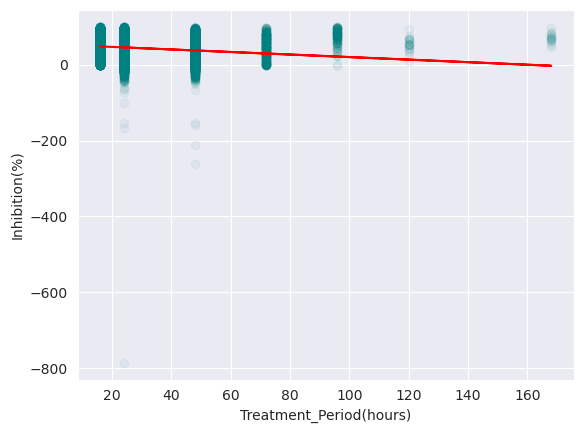

Inhibition(%)
Feature:  exp_ps_hybr
P:-0.08 p-value 1.7e-38
S:-0.047 p-value 2.7e-14


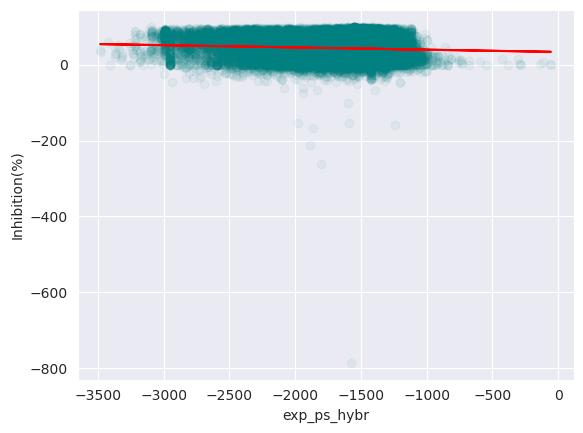

Inhibition(%)
Feature:  at_rich_region_score
P:0.0094 p-value 0.13
S:-0.0033 p-value 0.6


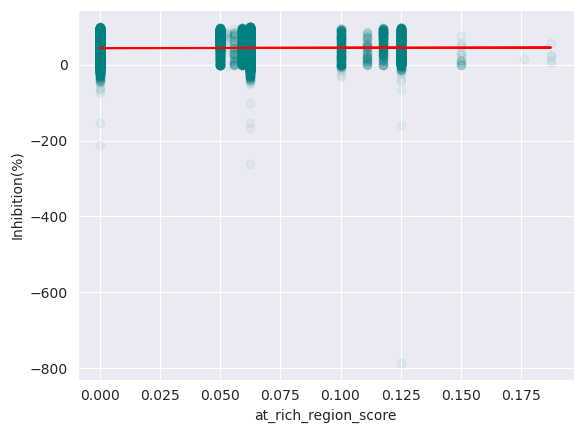

Inhibition(%)
Feature:  at_skew
P:-0.16 p-value 4.1e-150
S:-0.16 p-value 3.5e-141


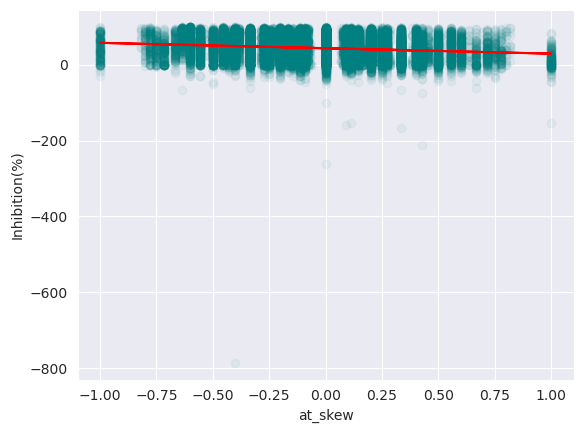

Inhibition(%)
Feature:  entropy
P:0.044 p-value 1.1e-12
S:0.045 p-value 2.8e-13


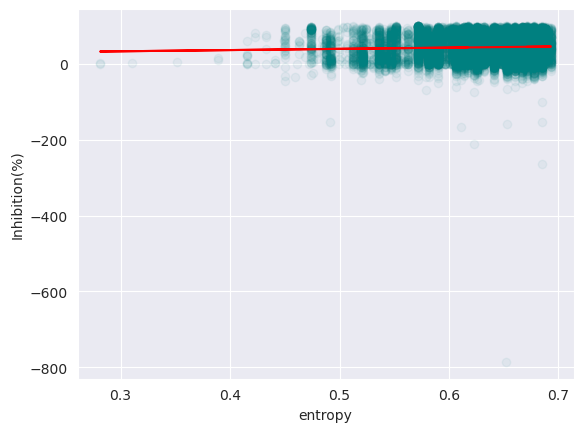

Inhibition(%)
Feature:  gc_content
P:-0.07 p-value 2.2e-29
S:-0.052 p-value 2.9e-17


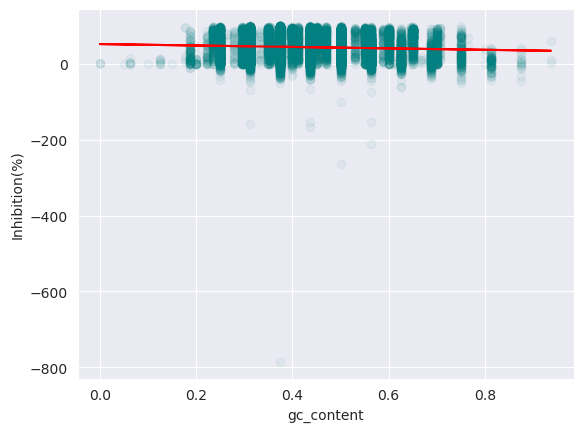

Inhibition(%)
Feature:  gc_content_3_prime_5
P:-0.019 p-value 0.0024
S:-0.014 p-value 0.027


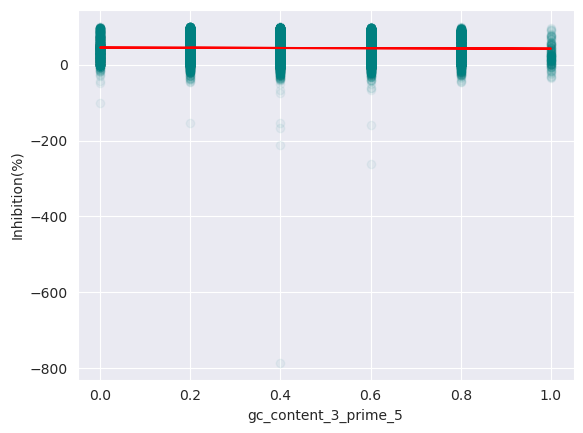

Inhibition(%)
Feature:  gc_skew
P:0.11 p-value 1.1e-69
S:0.1 p-value 2.4e-59


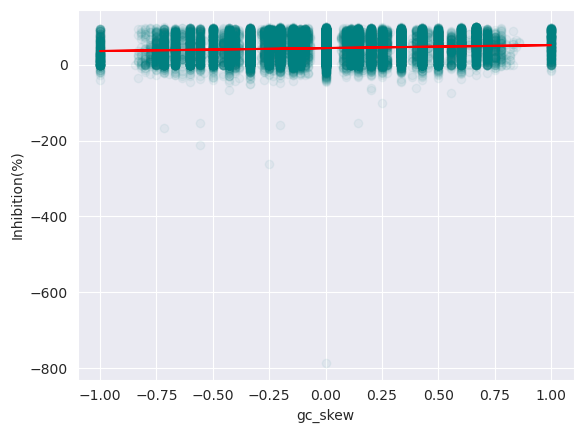

Inhibition(%)
Feature:  hairpin_score
P:-0.037 p-value 2e-09
S:-0.021 p-value 0.00062


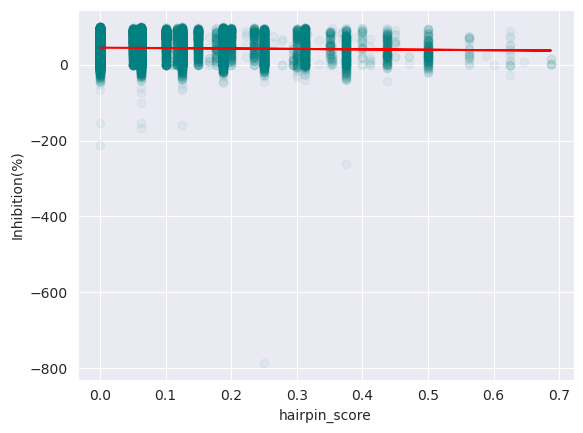

Inhibition(%)
Feature:  homooligo_count
P:-0.015 p-value 0.019
S:-0.014 p-value 0.022


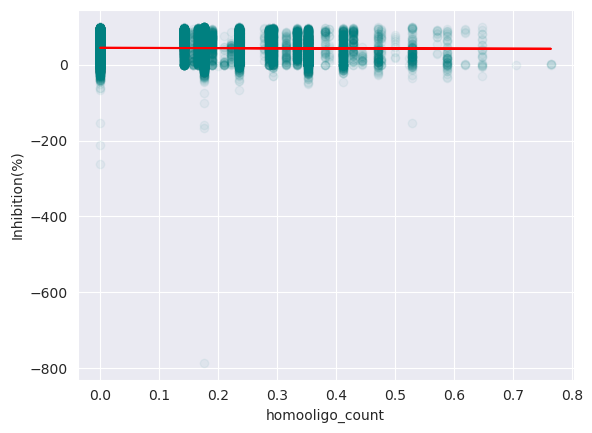

Inhibition(%)
Feature:  internal_fold
P:-0.0021 p-value 0.73
S:0.002 p-value 0.75


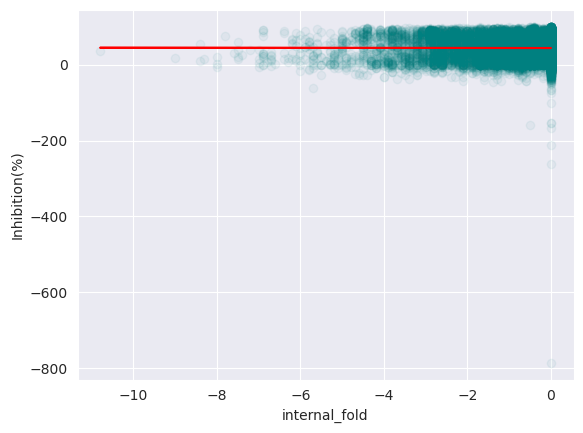

Inhibition(%)
Feature:  normalized_start
P:0.14 p-value 4.4e-108
S:0.14 p-value 5.1e-109


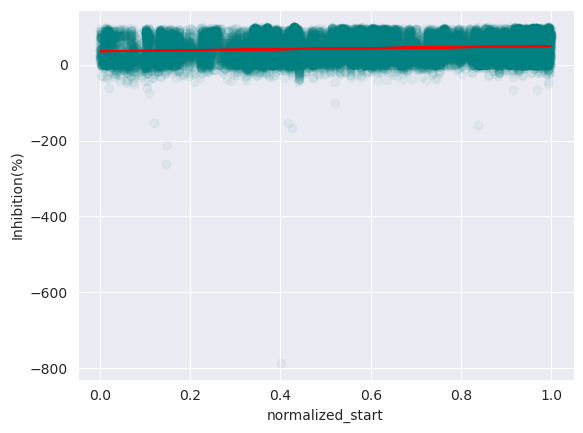

Inhibition(%)
Feature:  nucleotide_diversity
P:0.097 p-value 8.9e-56
S:0.09 p-value 2.2e-48


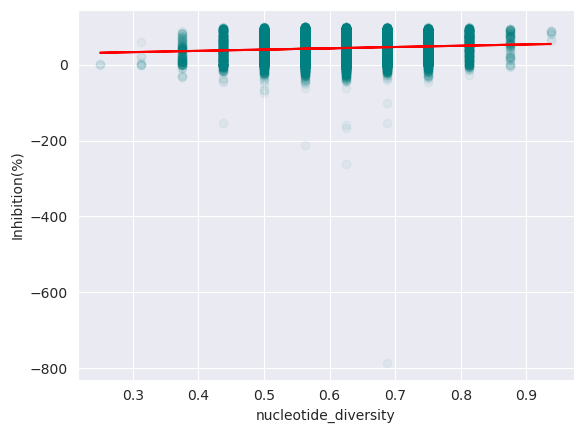

Inhibition(%)
Feature:  poly_pyrimidine_stretch
P:0.038 p-value 1.3e-09
S:0.018 p-value 0.0042


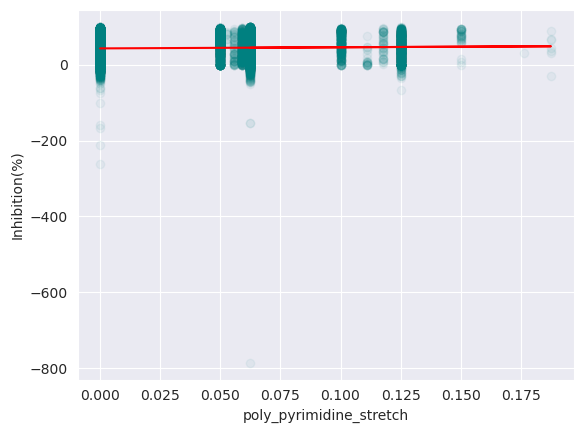

Inhibition(%)
Feature:  self_energy
P:0.021 p-value 0.00054
S:0.014 p-value 0.029


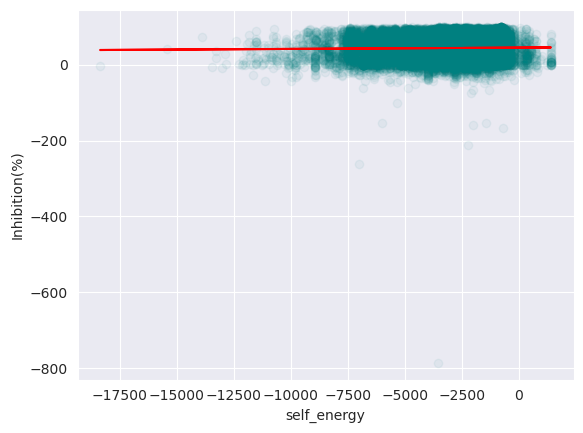

Inhibition(%)
Feature:  stop_codon_count
P:-0.016 p-value 0.0078
S:-0.032 p-value 2.2e-07


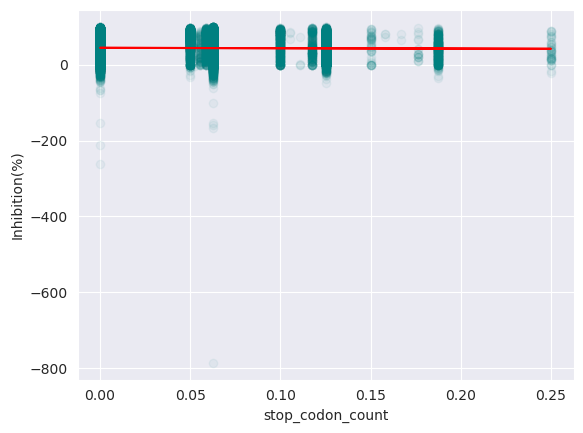

Inhibition(%)
Feature:  sense_exon
P:-0.008 p-value 0.2
S:-0.011 p-value 0.09


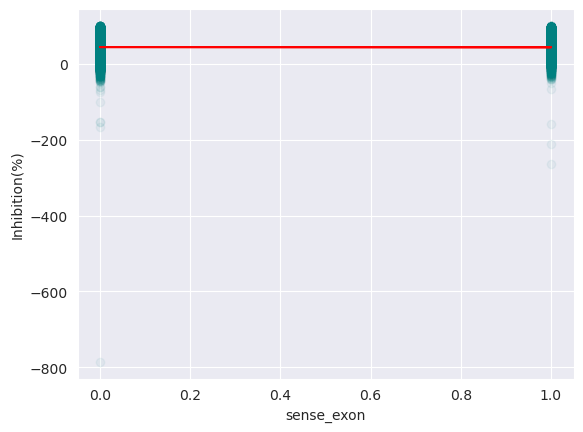

Inhibition(%)
Feature:  sense_intron
P:-0.015 p-value 0.015
S:-0.013 p-value 0.034


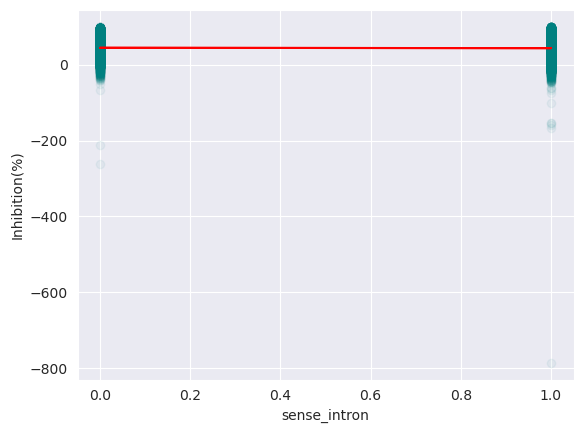

Inhibition(%)
Feature:  sense_utr
P:0.09 p-value 4.8e-48
S:0.089 p-value 1.4e-46


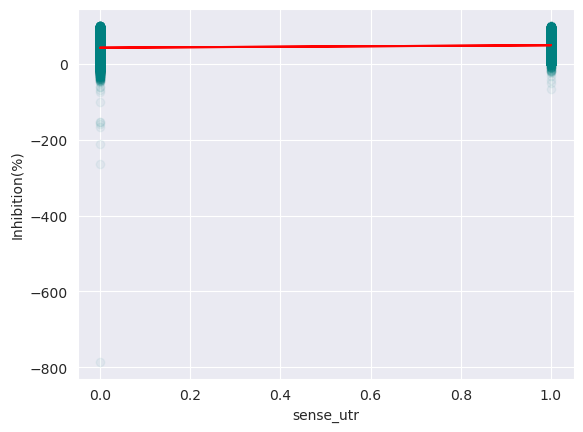

Inhibition(%)
Feature:  on_target_fold_openness_normalized40_15
P:0.22 p-value 2e-271
S:0.19 p-value 7.6e-216


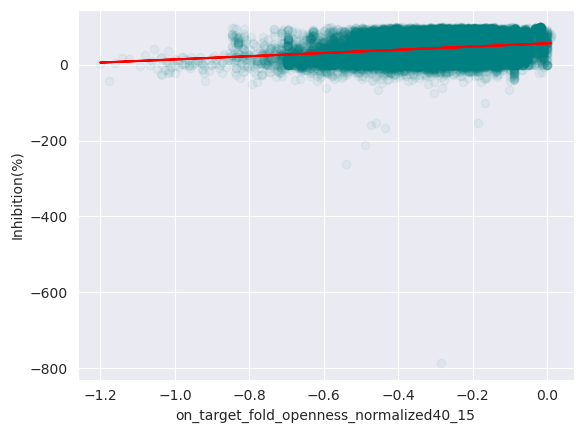

P:  0.4779924444139708
S:  0.47748804420295926
PTRAIN:  0.4835026840055346
PTEST:  0.4552240671647469
STRAIN:  0.484516161045719
STEST:  0.44952604247812256
PvaluePtest:  1.042803659816167e-264
PValueStest:  2.2229665233796526e-257


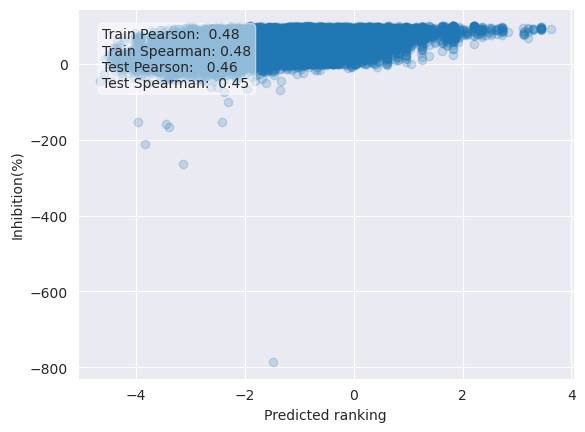

In [19]:
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, spearmanr

train_filtered = train.copy()
test_filtered = test.copy()

# train_filtered = train.nlargest(200, metric)
# test_filtered = test.nlargest(200, metric)

train_pred = model.predict(train_filtered[features].to_numpy())
test_pred = model.predict(test_filtered[features].to_numpy())

y_test = test_filtered[metric].to_numpy()
y_train = train_filtered[metric].to_numpy()

cell_lines = filtered[CELL_LINE].unique()
# for cell_line in cell_lines:
for cell_line in cell_lines:
    cell_line_mask = filtered[CELL_LINE] == cell_line
    print(f"cell-line:{cell_line}, length:{cell_line_mask.sum()} ", cell_line)
    print(metric)

    for gene in filtered[cell_line_mask][CANONICAL_GENE].unique():
        hepa_mask = cell_line_mask & (filtered[CANONICAL_GENE] == gene)
        print(f"gene-{gene} length: {hepa_mask.sum()}")
        # for f in ['sense_exon', 'sense_intron', 'sense_utr']:
        for f in ['NA']:
            # hep_pred = filtered[hepa_mask][f].to_numpy()
            # print(f"{f}: {filtered[hepa_mask][f].sum()} / {hepa_mask.sum()}")
            hep_pred = model.predict(filtered[hepa_mask][features].to_numpy())
            hepa_truth = filtered[hepa_mask][metric]
            p_hepa, pp_value = pearsonr(hepa_truth, hep_pred)
            s_hepa, sp_value = spearmanr(hepa_truth, hep_pred)
            print(f"P:{p_hepa:.2}, p-value: {pp_value:.2}")
            print(f"S:{s_hepa:.2} , p-value: {sp_value:.2}")

for feature in features:
    # EXAMPLE = 'GGCATATGCAGATAATGTTC'

    # malat_mask = filtered[CELL_LINE] == 'U251'

    # malat_mask = filtered[CANONICAL_GENE] == "HSD17B13"
    # malat_mask = filtered[CANONICAL_GENE] == "MALAT1"
    malat_mask = filtered[CANONICAL_GENE] != "AAA"
    # example_mask = (filtered[CANONICAL_GENE] == "MALAT1") & (filtered[SEQUENCE] == EXAMPLE)
    malat_pred = model.predict(filtered[malat_mask][features].to_numpy())
    print(metric)
    malat_truth = filtered[malat_mask][metric]
    p_hepa, pp_value = pearsonr(malat_truth, filtered[malat_mask][feature])
    s_hepa, sp_value = spearmanr(malat_truth, filtered[malat_mask][feature])

    # plt.scatter(filtered[malat_mask][feature], malat_truth)
    # example_df = filtered.loc[example_mask, :].copy()
    # plt.scatter(example_df[feature], malat_truth[example_mask], color='orange')
    plt.scatter(filtered[malat_mask][feature], malat_truth, color='teal', alpha=0.05)
    m, b = np.polyfit(filtered[malat_mask][feature], malat_truth, 1)
    plt.plot(filtered[malat_mask][feature], m*filtered[malat_mask][feature] + b, color='red')
    plt.xlabel(feature)
    plt.ylabel(metric)
    print("Feature: ", feature)
    print(f"P:{p_hepa:.2} p-value {pp_value:.2}")
    print(f"S:{s_hepa:.2} p-value {sp_value:.2}")
    plt.show()

p_hepa, _ = pearsonr(malat_truth, malat_pred)
s_hepa, _ = spearmanr(malat_truth, malat_pred)
print("P: ", p_hepa)
print("S: ", s_hepa)

p_train, _ = pearsonr(y_train, train_pred)
s_train, _ = spearmanr(y_train, train_pred)
p_test, p_value_ptest = pearsonr(y_test, test_pred)
s_test, p_value_stest = spearmanr(y_test, test_pred)

print("PTRAIN: ", p_train)
print("PTEST: ", p_test)
print("STRAIN: ", s_train)
print("STEST: ", s_test)
print("PvaluePtest: ", p_value_ptest)
print("PValueStest: ", p_value_stest)

# scatter plot
# plt.scatter(test_pred, y_test, alpha=0.2)
plt.scatter(malat_pred, malat_truth, alpha=0.2)

# least‑squares regression line
# slope, intercept = np.polyfit(test_pred, y_test, 1)
# x = np.linspace(test_pred.min(), test_pred.max(), 100)
# plt.plot(x, slope * x + intercept, color='red')

# labels and stats
plt.xlabel('Predicted ranking')
plt.ylabel(metric)
txt = (
    f"Train Pearson:  {p_train:.2f}\n"
    f"Train Spearman: {s_train:.2f}\n"
    f"Test Pearson:   {p_test:.2f}\n"
    f"Test Spearman:  {s_test:.2f}"
)
plt.text(
    0.05, 0.95, txt,
    transform=plt.gca().transAxes,
    va='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5)
)

plt.show()


In [20]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

In [21]:
def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


# def correction(df):
#     return (df['log_volume'])

# def correction(df):
#     return (df[VOLUME]) / df[VOLUME]

def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)


#

for percentile in [1, 5, 10, 50]:
    threshold = get_threshold_for_percentile(percentile, log_inhibition_to_regular(filtered['log_inhibition']))
    # print(correction(filtered))
    # print(log_inhibition_to_regular(filtered['log_inhibition']))
    print(f"Threshold for top_{percentile}: {threshold}")

Threshold for top_1: 96.0
Threshold for top_5: 90.0
Threshold for top_10: 85.0
Threshold for top_50: 43.99999999999999


In [73]:
def correction(df):
    return df[VOLUME] / (df[VOLUME] + 10)

def correction2(df):
    return (df[VOLUME] * 0.0000601 + 0.537)

def log_inhibition_to_regular(log_inhibition, log_correction):
    return 100 * (-np.exp(-log_inhibition) + log_correction)

def get_threshold_for_percentile(percentile, df):
    k = max(1, int(np.ceil((percentile / 100) * len(df))))  # desired count
    threshold = np.partition(df, -k)[-k]  # value at 99th percentile
    return threshold


def evaluate_top(model, test, metric, features, log_correction, top_k=None, plot=False, percentile=0.5):
    test_filtered = test.copy()
    test_pred = model.predict(test_filtered[features].to_numpy())

    if top_k is not None:
        test_mask = np.zeros_like(test_pred, dtype=bool)
        top_k_idx = np.argsort(test_pred)[-top_k:]
        test_mask[top_k_idx] = True
    else:
        percentile = 0.5
        test_threshold = get_threshold_for_percentile(percentile, test_pred)
        test_mask = test_pred > test_threshold
        top_k = test_mask.sum()

    y_test = test_filtered[metric].to_numpy()
    if metric == INHIBITION:
        top_test = y_test[test_mask]
        all_inhib = pd.Series(y_test)
    elif metric == 'log_inhibition':
        top_test = log_inhibition_to_regular(y_test[test_mask], log_correction)
        all_inhib = pd.Series(log_inhibition_to_regular(y_test, log_correction))
    elif metric == 'correct_log_inhibition':
        top_test = log_inhibition_to_regular(y_test[test_mask] * correction(test_filtered[test_mask]), log_correction)
        all_inhib = log_inhibition_to_regular(y_test * correction(test_filtered), log_correction)
    elif metric == 'correct_log_inhibition2':
        top_test = log_inhibition_to_regular(y_test[test_mask] * correction2(test_filtered[test_mask]), log_correction)
        all_inhib = log_inhibition_to_regular(y_test * correction2(test_filtered), log_correction)
    else:
        raise ValueError(f"Unknown metric {metric}")

    # ---------- best possible ----------
    top_best = all_inhib.nlargest(top_k).to_numpy()  # no index confusion

    # random sample via mask
    # k already computed as the desired sample size
    rand_mask = np.zeros(len(y_test), dtype=bool)
    rand_mask[np.random.choice(len(y_test), top_k, replace=False)] = True

    top_rand_test = all_inhib[rand_mask]

    mean_model, mean_best, mean_random = np.mean(top_test), np.mean(top_best), np.mean(top_rand_test)

    if plot:
        bins = np.array([-50, 0, 10, 20, 30, 40, 50, 60, 70, 80, 85, 90, 95, 97, 100])
        x = (bins[:-1] + bins[1:]) / 2

        fig, ax = plt.subplots(figsize=(4, 4), facecolor="none")  # transparent figure
        fig.patch.set_alpha(0.0)
        ax.set_facecolor("none")  # transparent axes background

        # --- Predicted: thick line, darker fill ---------------------------------
        h_pred, _ = np.histogram(top_test, bins=bins)
        ax.plot(x, h_pred, drawstyle='steps-mid', lw=3.2, color='C0',
                label='Predicted', zorder=5)
        ax.fill_between(x, 0, h_pred, step='mid', alpha=0.35, color='C0', zorder=4)

        # --- Others: thinner, lighter -------------------------------------------
        for arr, lab, c in [(top_rand_test, 'Random', 'C1'),
                            (top_best, 'Best', 'C2')]:
            h, _ = np.histogram(arr, bins=bins)
            ax.plot(x, h, drawstyle='steps-mid', lw=1.3, color=c, alpha=0.7, label=lab, zorder=3)
            ax.fill_between(x, 0, h, step='mid', alpha=0.10, color=c, zorder=2)

        # ax.set_yscale('log')        # drop if you don't want log
        ax.set_xlabel('Inhibition (%)', fontweight='bold')
        ax.set_ylabel('ASO count (log-scale)', fontweight='bold')
        ax.set_title('Distribution of Predicted vs Random vs Best\n Top 0.5% ', fontweight='bold')

        ax.legend(frameon=False, fontsize=11)

        fig.tight_layout()
        plt.show()

    return mean_model, mean_best, mean_random

In [83]:
bak = filtered.copy()

In [109]:
from sklearn.metrics import ndcg_score

from scripts.Models.model_helpers import evaluate_top

only_cancer = bak
only_cancer = only_cancer[
    # (~((filtered_original[CELL_LINE] == 'HepG2') & (filtered_original[TRANSFECTION].str.contains('Lipo')))) &
    (only_cancer[CELL_LINE] != 'HepG2')  # experiment settings too different
    & (only_cancer[CELL_LINE] != 'HepaRG')  # not similar to cancer
    & (only_cancer[CELL_LINE] != 'A-431')
    ]

min_val = only_cancer['correct_log_inhibition'].min()
only_cancer['correct_log_inhibition_ndcg'] = (
    only_cancer['correct_log_inhibition'] - min_val
)

# only_cancer = bak[bak[CELL_LINE].isin(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'])]
# print(bak[CELL_LINE].unique())
# print(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'])
seed = 42

log_correction = 1.01
only_cancer.loc[:, 'log_inhibition'] = -np.log(log_correction - only_cancer[INHIBITION] / 100)
only_cancer['correct_log_inhibition'] = li / (only_cancer[VOLUME] / (only_cancer[VOLUME] + 10))

print("Used cell lines: ", only_cancer[CELL_LINE].unique())
for cell_line in ['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28']:
    if len(only_cancer[CELL_LINE]) < 100:
        continue
    print(f"Cell line {cell_line}, samples: {len(only_cancer[only_cancer[CELL_LINE]==cell_line])}")
    current_filtered = only_cancer[only_cancer[CELL_LINE] != cell_line].copy()
    train, test = train_test_split(current_filtered, test_size=0.2, random_state=seed)
    current_filtered = train
    current_filtered['group_key'] = current_filtered[CELL_LINE].astype(str)
    # train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
    current_filtered = current_filtered.sort_values('group_key')
    group_train = current_filtered.groupby('group_key').size().tolist()

    # metric = 'correct_log_inhibition2'
    metric = 'correct_log_inhibition'
    # metric= 'log_inhibition'
    # metric = INHIBITION

    X = current_filtered[features]
    y = current_filtered[metric]

    model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed, n_jobs=-1)
    # model = XGBRanker(objective='rank:pairwise')
    model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
    missing_cell_line = only_cancer[only_cancer[CELL_LINE] == cell_line]
    top = evaluate_top(model, missing_cell_line, metric, features, log_correction, top_k=50)
    print(top)

    y_true = missing_cell_line[metric].to_numpy()
    y_pred = model.predict(missing_cell_line[features].to_numpy())

    print(spearmanr(y_pred, y_true))


    y_true_corrected = missing_cell_line['correct_log_inhibition_ndcg'].to_numpy()
    # ---- New metrics ----
    # NDCG@50
    ndcg50 = ndcg_score(y_true_corrected.reshape(1, -1), y_pred.reshape(1, -1), k=200)
    # NDCG (all, just drop k)
    ndcg_all = ndcg_score(y_true_corrected.reshape(1, -1), y_pred.reshape(1, -1))
    # Precision@50 (manual overlap of top-50 by truth vs pred)
    precisions = []
    values = [50, 100]
    for K in values:
        pred_top_idx = np.argpartition(y_pred, -K)[-K:]
        true_top_idx = np.argpartition(y_true_corrected, -K)[-K:]
        precisions.append(len(set(pred_top_idx) & set(true_top_idx)) / K)

    print(f"NDCG@50: {ndcg50:.4f}, NDCG(all): {ndcg_all:.4f}, Precision: {values, precisions}")

/tmp/ipykernel_667667/2322861172.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_cancer['correct_log_inhibition_ndcg'] = (
/tmp/ipykernel_667667/2322861172.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_cancer['correct_log_inhibition'] = li / (only_cancer[VOLUME] / (only_cancer[VOLUME] + 10))


Used cell lines:  ['A431' 'NCI-H460' 'Human IPS' 'KARPAS-229' 'MM.1R' 'SK-MEL-28' 'H929'
 'KMS11' 'SNU-449' 'U251']
Cell line A431, samples: 6541
(67.84, 99.2, 44.1)
SignificanceResult(statistic=0.1593664093737193, pvalue=1.8222901907244883e-38)
NDCG@50: 0.5192, NDCG(all): 0.9570, Precision: ([50, 100], [0.0, 0.0])
Cell line KARPAS-229, samples: 972
(47.96, 81.6, 27.1)
SignificanceResult(statistic=0.24204819779101405, pvalue=1.9996510191468265e-14)
NDCG@50: 0.8576, NDCG(all): 0.9761, Precision: ([50, 100], [0.06, 0.12])
Cell line MM.1R, samples: 3394
(54.16, 92.82, 36.1)
SignificanceResult(statistic=0.40052340830122823, pvalue=5.540605189764532e-131)
NDCG@50: 0.7929, NDCG(all): 0.9804, Precision: ([50, 100], [0.02, 0.07])
Cell line SK-MEL-28, samples: 2836
(57.48, 88.86, 28.54)
SignificanceResult(statistic=0.2815824366346387, pvalue=7.714691086473249e-53)
NDCG@50: 0.8428, NDCG(all): 0.9826, Precision: ([50, 100], [0.12, 0.17])


In [111]:
from sklearn.metrics import ndcg_score
from scripts.Models.model_helpers import evaluate_top

# SL MODEL


filtered = bak
only_cancer = bak[bak[CELL_LINE].isin(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'])]
# print(bak[CELL_LINE].unique())
# print(['A431', 'KARPAS-229', 'MM.1R', 'SK-MEL-28', 'SNU-449', 'U251'])
seed = 42

log_correction = 1.01
only_cancer.loc[:, 'log_inhibition'] = -np.log(log_correction - only_cancer[INHIBITION] / 100)
only_cancer['correct_log_inhibition'] = li / (only_cancer[VOLUME] / (only_cancer[VOLUME] + 10))
min_val = only_cancer['correct_log_inhibition'].min()
only_cancer['correct_log_inhibition_ndcg'] = (
    only_cancer['correct_log_inhibition'] - min_val
)

print("Used cell lines: ", only_cancer[CELL_LINE].unique())
for cell_line in ['A431', 'SK-MEL-28', 'KARPAS-229', 'MM.1R']:
    if len(only_cancer[CELL_LINE]) < 100:
        continue
    print(f"Cell line {cell_line}, samples: {len(only_cancer[only_cancer[CELL_LINE]==cell_line])}")
    current_filtered = only_cancer[only_cancer[CELL_LINE] != cell_line].copy()
    train, test = train_test_split(current_filtered, test_size=0.2, random_state=seed)
    current_filtered = train
    current_filtered['group_key'] = current_filtered[CELL_LINE].astype(str)
    # train['group_key'] = train[CELL_LINE].astype(str) + '_' + train[CANONICAL_GENE].astype(str)
    current_filtered = current_filtered.sort_values('group_key')
    group_train = current_filtered.groupby('group_key').size().tolist()

    # metric = 'correct_log_inhibition2'
    metric = 'correct_log_inhibition'
    # metric= 'log_inhibition'
    # metric = INHIBITION

    X = current_filtered[features]
    y = current_filtered[metric]

    model = XGBRanker(objective='rank:ndcg', ndcg_exp_gain=False, lambdarank_pair_method="topk", seed=seed, n_jobs=-1)
    # model = XGBRanker(objective='rank:pairwise')
    model.fit(X.to_numpy(), y.to_numpy(), group=group_train)
    missing_cell_line = only_cancer[only_cancer[CELL_LINE] == cell_line]
    top = evaluate_top(model, missing_cell_line, metric, features, log_correction, top_k=50)
    print(top)

    y_true = missing_cell_line[metric].to_numpy()
    y_pred = model.predict(missing_cell_line[features].to_numpy())

    print(spearmanr(y_pred, y_true))


    y_true_corrected = missing_cell_line['correct_log_inhibition_ndcg'].to_numpy()
    # ---- New metrics ----
    # NDCG@50
    ndcg50 = ndcg_score(y_true_corrected.reshape(1, -1), y_pred.reshape(1, -1), k=200)
    # NDCG (all, just drop k)
    ndcg_all = ndcg_score(y_true_corrected.reshape(1, -1), y_pred.reshape(1, -1))
    # Precision@50 (manual overlap of top-50 by truth vs pred)
    precisions = []
    values = [50, 100]
    for K in values:
        pred_top_idx = np.argpartition(y_pred, -K)[-K:]
        true_top_idx = np.argpartition(y_true_corrected, -K)[-K:]
        precisions.append(len(set(pred_top_idx) & set(true_top_idx)) / K)

    print(f"NDCG@50: {ndcg50:.4f}, NDCG(all): {ndcg_all:.4f}, Precision: {values, precisions}")

/tmp/ipykernel_667667/1794158564.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_cancer['correct_log_inhibition'] = li / (only_cancer[VOLUME] / (only_cancer[VOLUME] + 10))
/tmp/ipykernel_667667/1794158564.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_cancer['correct_log_inhibition_ndcg'] = (


Used cell lines:  ['A431' 'KARPAS-229' 'MM.1R' 'SK-MEL-28' 'SNU-449' 'U251']
Cell line A431, samples: 6541
(34.66, 99.2, 46.82)
SignificanceResult(statistic=0.13401711429990865, pvalue=1.3456982611728674e-27)
NDCG@50: 0.4914, NDCG(all): 0.9532, Precision: ([50, 100], [0.0, 0.01])
Cell line SK-MEL-28, samples: 2836
(61.22, 88.86, 41.24)
SignificanceResult(statistic=0.2637404964855456, pvalue=2.424113115426312e-46)
NDCG@50: 0.8358, NDCG(all): 0.9814, Precision: ([50, 100], [0.04, 0.17])
Cell line KARPAS-229, samples: 972
(33.18, 81.6, 27.32)
SignificanceResult(statistic=0.25314381193950525, pvalue=1.1198448037873859e-15)
NDCG@50: 0.8389, NDCG(all): 0.9748, Precision: ([50, 100], [0.0, 0.01])
Cell line MM.1R, samples: 3394
(52.5, 92.82, 26.7)
SignificanceResult(statistic=0.4232170457036453, pvalue=1.3628237383603233e-147)
NDCG@50: 0.8105, NDCG(all): 0.9814, Precision: ([50, 100], [0.12, 0.18])
